# Import

In [ ]:
from diffusers import AutoencoderKL
from transformers import CLIPProcessor, CLIPModel
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torch
from transformers import CLIPProcessor, CLIPVisionModel
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import csv
from tqdm import tqdm

from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, DiTPipeline, DDIMScheduler

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Globals

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
class DatasetCVUSA(Dataset):
    def __init__(self, list_path, root_dir, transform_ground=None, transform_sat=None):
        self.root_dir = root_dir
        self.transform_ground = transform_ground
        self.transform_sat = transform_sat

        self.image_ids = []

        with open(list_path, "r") as f:
            reader = csv.reader(f, delimiter=',')
            for row in reader:
                streetview_path = row[1]
                filename = os.path.basename(streetview_path)
                if filename.startswith("input"):
                    filename = filename[len("input"):]
                image_id = os.path.splitext(filename)[0]
                self.image_ids.append(image_id)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        ground_path = os.path.join(self.root_dir, "streetview", f"{image_id}.jpg")
        sat_path = os.path.join(self.root_dir, "bingmap", f"input{image_id}.png")

        ground_img = Image.open(ground_path).convert("RGB")
        sat_img = Image.open(sat_path).convert("RGB")

        if self.transform_ground:
            ground_img = self.transform_ground(ground_img)
        if self.transform_sat:
            sat_img = self.transform_sat(sat_img)

        return ground_img, sat_img

In [ ]:

IMG_SIZE = 256

In [ ]:
dataset_root = "/content/drive/MyDrive/Dataset_Computer_Vision/Dataset_CVUSA/Dataset_CVUSA"
split_file = os.path.join(dataset_root, "train-19zl.csv")
split_file_val = os.path.join(dataset_root, "val-19zl.csv")

val_dataset = DatasetCVUSA(
    root_dir=dataset_root,
    list_path=split_file_val,
    transform_ground=transform_rgb,
    transform_sat=transform_rgb
)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers = 4)

# Model

In [ ]:

unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(device)
model = unet.to(device)

checkpoint = torch.load('/content/drive/MyDrive/unet_checkpoint_epoch45.pth', map_location=device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [ ]:

clip_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [ ]:
unet.eval()
vae.eval()
clip_model.eval()

CLIPVisionModel(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (position_embedding): Embedding(50, 768)
    )
    (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
        

# Utils

In [ ]:
transform_rgb = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_seg = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Load data

In [ ]:

ground_img_path = "/content/drive/MyDrive/Dataset_Computer_Vision/Dataset_CVUSA/Dataset_CVUSA/streetview/0000008.jpg"
ground_img = Image.open(ground_img_path).convert("RGB")
ground_tensor = transform_rgb(ground_img).unsqueeze(0).to(device)  # shape: [1, 3, 256, 256]

# Image generation

In [ ]:

with torch.no_grad():
    clip_inputs = clip_processor(images=ground_img, return_tensors="pt").to(device)
    encoder_hidden_states = clip_model(**clip_inputs).last_hidden_state  # shape [1, 257, 768]


latents = torch.randn((1, 4, 32, 32), device=device)
scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
scheduler.set_timesteps(50)


with torch.no_grad():
    for t in scheduler.timesteps:
        latent_model_input = latents
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=encoder_hidden_states).sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample


with torch.no_grad():
    image = vae.decode(latents / 0.18215).sample
    image = (image.clamp(-1, 1) + 1) / 2  # [0, 1]
    image = image.cpu().permute(0, 2, 3, 1).numpy()[0]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128752 (\N{SATELLITE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


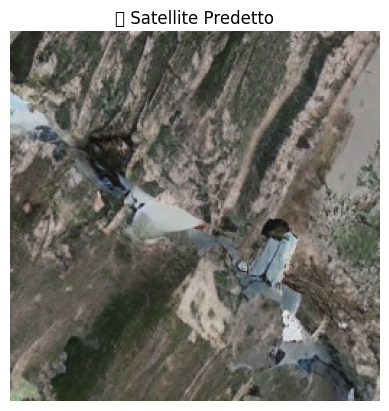

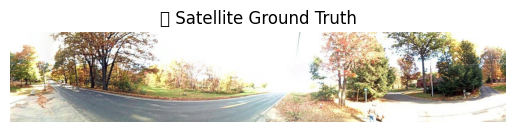

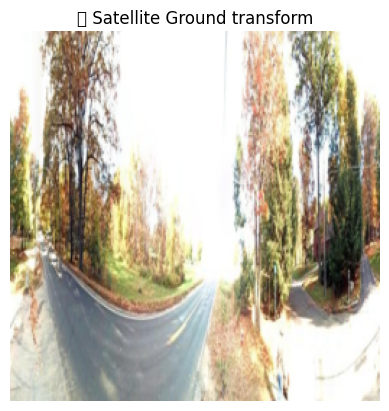

In [ ]:
plt.imshow(image)
plt.axis("off")
plt.title(" Satellite Predetto")
plt.show()

plt.imshow(ground_img)
plt.axis("off")
plt.title(" Satellite Ground Truth")
plt.show()

plt.imshow(((ground_tensor.cpu().squeeze(0).permute(1, 2, 0) + 1) / 2).numpy())
plt.axis("off")
plt.title(" Satellite Ground transform")
plt.show()

In [ ]:

generated_images = []


for i, (ground_img, sat_img) in enumerate(tqdm(val_loader)):
    ground_img = ground_img.to(device)
    ground_img_unnormalized = (ground_img + 1) / 2

    with torch.no_grad():
        clip_inputs = clip_processor(images=ground_img_unnormalized, return_tensors="pt", do_rescale = False).to(device)
        encoder_hidden_states = clip_model(**clip_inputs).last_hidden_state

        latents = torch.randn((1, 4, 32, 32), device=device)
        scheduler.set_timesteps(50) # o 25?

        for t in scheduler.timesteps:
            latent_model_input = latents
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=encoder_hidden_states).sample
            latents = scheduler.step(noise_pred, t, latents).prev_sample

        image = vae.decode(latents / 0.18215).sample
        image = (image.clamp(-1, 1) + 1) / 2  # normalize to [0, 1]
        image_np = image.cpu().permute(0, 2, 3, 1).numpy()[0]

        output_path = f"/content/generated_images/generated_{i:04d}.png"
        os.makedirs("/content/generated_images", exist_ok=True)
        Image.fromarray((image_np * 255).astype("uint8")).save(output_path)


100%|██████████| 2215/2215 [1:36:59<00:00,  2.63s/it]


In [ ]:
!cp -r /content/generated_images /content/drive/MyDrive